# Intro to Kalman Filters and IMU

This Notebook contains implementation of Extended Kalman Filter to generate Quaternions from the multi-sensor data of Accelerometer, Gyroscope and Magentometer.

Things done in the Notebook so far:
* Clean Data to handle the newline skip condition
* Visualized 3D accelerometer and Magnetometer Data Temporaly
* Double Integrate Accelerometer Data to produce (BAD) Position Result
* Generate Quaternions from sensor data using [AHRS library][1]
* Convert the Quaternions to Rotation Matrix
* Get Clean Linear Acceleration from MATMUL on the Transposed Rotation Matrix and Orignal Acceleration
* Double Integrate the Clean Linear Accelerometer Data to produce (Better) Position Result


[1]:https://pypi.org/project/AHRS/

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from dataclasses import dataclass

import matplotlib.pyplot as plt # visualization
plt.rcParams.update({'font.size': 14})
import seaborn as sns # visualization

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

In [5]:
from tqdm import tqdm
from pathlib import Path
import json
import plotly.graph_objs as go
from PIL import Image
from datetime import datetime

from ahrs.filters import EKF
from ahrs.common.orientation import acc2q
from ahrs.utils import WMM
from scipy.spatial.transform import Rotation as R
from scipy import integrate

### Taking a Look at the text files

### Trajectory of the Waypoints

In [6]:
data=pd.read_csv('datasets/data.csv')
data.head()

,Packet number,Gyroscope X (deg/s),Gyroscope Y (deg/s),Gyroscope Z (deg/s),Accelerometer X (g),Accelerometer Y (g),Accelerometer Z (g),Magnetometer X (G),Magnetometer Y (G),Magnetometer Z (G)
0,1682370858853858000,2.799556,1.084390,-0.398919,0.236698,1.282487,-0.379846,-24.146198,24.254318,10.229141
1,1682370858863891700,2.851976,1.103800,-0.432590,-0.087422,1.213181,-0.450783,-24.592518,24.391113,10.714066
2,1682370858873926000,2.884317,1.107588,-0.501149,-0.365480,1.230790,-0.341100,-24.674173,24.393303,11.206650
3,1682370858883960000,2.906043,1.112346,-0.603599,-0.621584,1.366319,-0.112145,-23.654703,24.221680,12.704082
4,1682370858893993700,2.911920,1.034627,-0.696554,-1.052875,1.535430,0.136091,-22.297655,24.042000,13.955418


In [7]:
data.shape

(2101, 10)

In [8]:
#3d plot the data 
from mpl_toolkits.mplot3d import Axes3D
def plot_3d_graph(x,y,z, c=None):
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection = '3d')

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.scatter(x, y, z, c=c)
    ax.set_title("acce")
    plt.show()

### Plotting cumulative sum of acceleration vector moving in time.

This should give us a general idea of which direction the change in motion is happening.

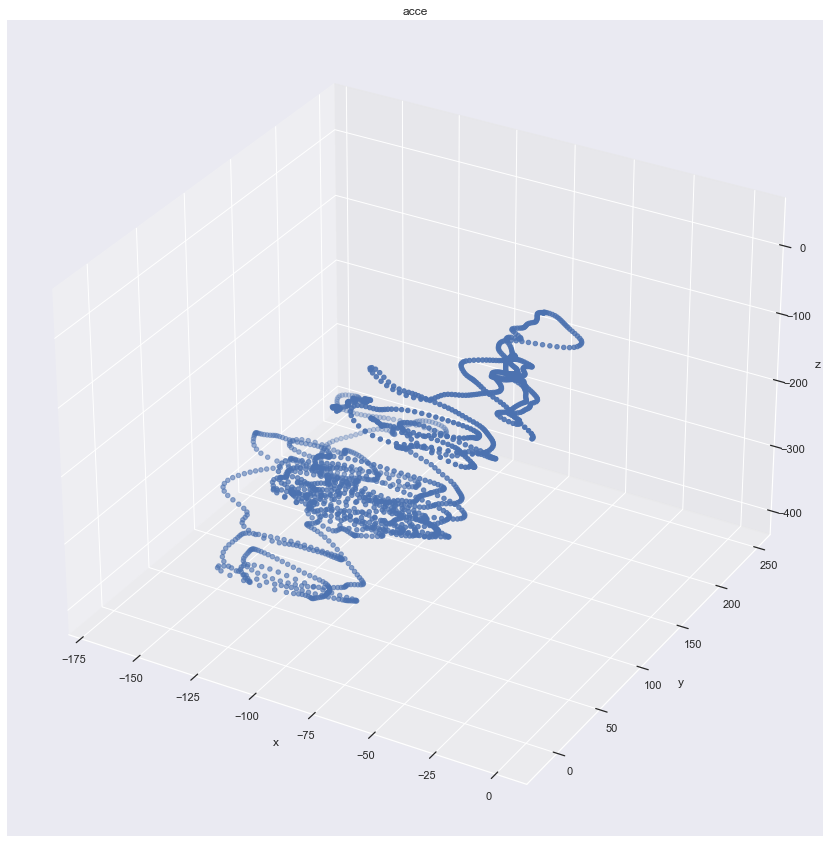

In [9]:
plot_3d_graph(
    np.cumsum(data['Accelerometer X (g)']),
    np.cumsum(data['Accelerometer Y (g)']),
    np.cumsum(data['Accelerometer Z (g)']),
)


### Double Integrating the Orignal Acceleration to Generate "BAD" Position Vectors (Noisy Data Makes the Integration Drift)

In [10]:
time_ = data['Packet number']

vel_x = integrate.cumtrapz(data['Accelerometer X (g)'], time_, initial=0)
vel_y = integrate.cumtrapz(data['Accelerometer Y (g)'], time_, initial=0)
vel_z = integrate.cumtrapz(data['Accelerometer Z (g)'], time_, initial=0)

pos_x = integrate.cumtrapz(vel_x, time_, initial=0)
pos_y = integrate.cumtrapz(vel_y, time_, initial=0)
pos_z = integrate.cumtrapz(vel_z, time_, initial=0)

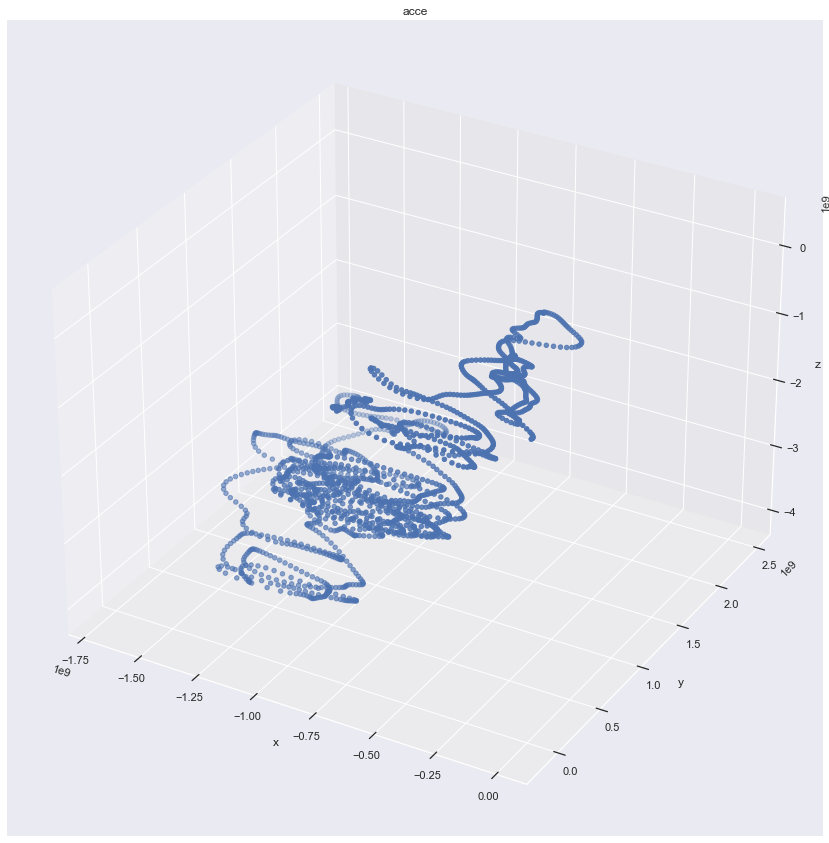

In [11]:
plot_3d_graph(
    vel_x,
    vel_y,
    vel_z,
)


### BAD Position Plot

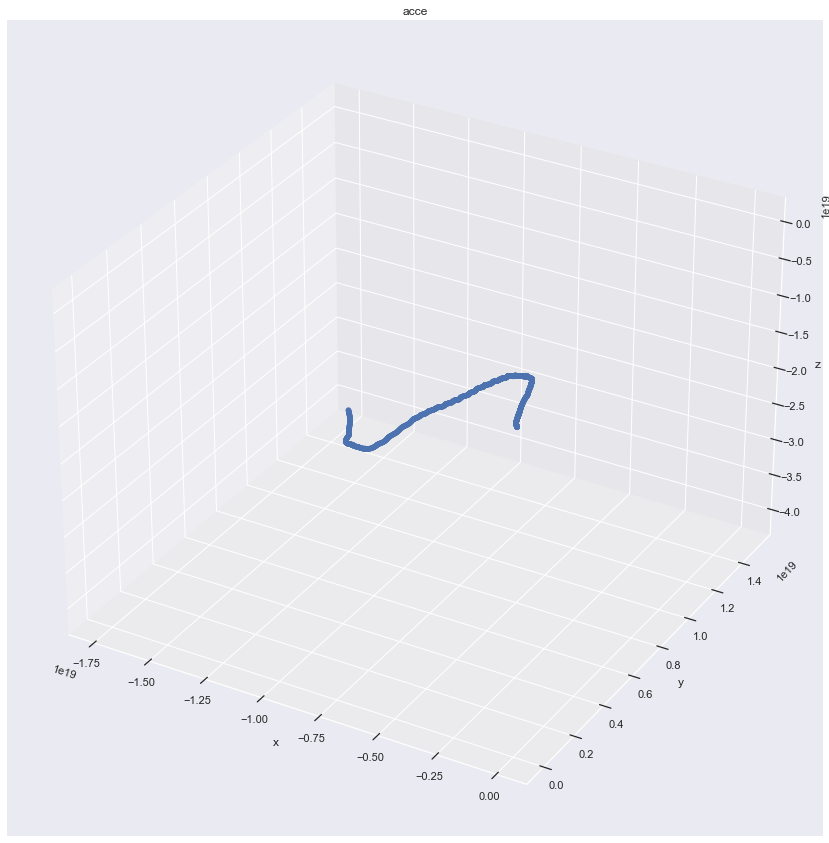

In [12]:
plot_3d_graph(
    pos_x,
    pos_y,
    pos_z,
)


### Plotting cumulative sum of magnetometer vector moving in time.

I dont know what to do from magnetometer readings but it still looks like there is a strong directional output to the sensor

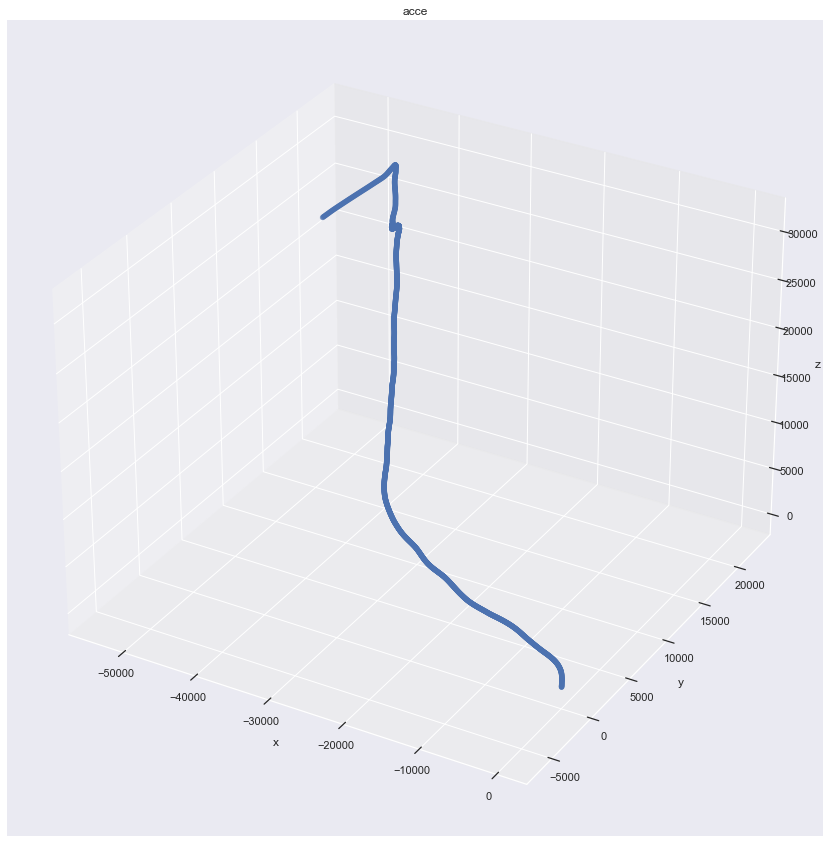

In [13]:
plot_3d_graph(
    np.cumsum(data['Magnetometer X (G)']),
    np.cumsum(data['Magnetometer Y (G)']),
    np.cumsum(data['Magnetometer Z (G)']),
)

### Using EKF from ahrs library, 
Note: the magnetometer readings are supposed to be added with a correction value to handle the True North vs Magnetic North seperation, I have not implemented this yet.


In [14]:
ekf_estimator = EKF(gyr=data.iloc[:,1:4].values, acc=data.iloc[:,4:7].values, mag=data.iloc[:,7:12].values, frequency=100.0)
# Initializing the class with the sensor data generates our Quaternion in the Q Variable

Q = ekf_estimator.Q
n_samples = data.shape[0]
new_acce = np.zeros((n_samples, 3))
# Initializing Array to hold the Linear acceleration Vector
data_acc=data.iloc[:,4:7].values
for t in range(n_samples):
    r = R.from_quat(Q[t])
    # Getting a Rotation Matrix from the Quaternions
    new_acce[t] = np.matmul(r.as_matrix().T,data_acc[t])
    # matmul Rotation Matrix Transpose to orignal Acceleration to produce the clean linear acceleration



In [15]:
print(' the clean linear acceleration')
print(new_acce)

 the clean linear acceleration
[[ 1.21087135e+00 -5.93844579e-01  1.61925496e-01]
 [ 8.83274476e-02 -1.18175998e+00 -5.27538374e-01]
 [-1.70255099e-01 -1.01115652e+00  8.44597100e-01]
 ...
 [-1.58618520e-01 -6.91484896e-02  9.81971211e-02]
 [ 7.76629569e-04 -6.14272051e-03  3.10448793e-02]
 [ 8.84121878e-02  3.01064911e-02 -5.66371317e-02]]


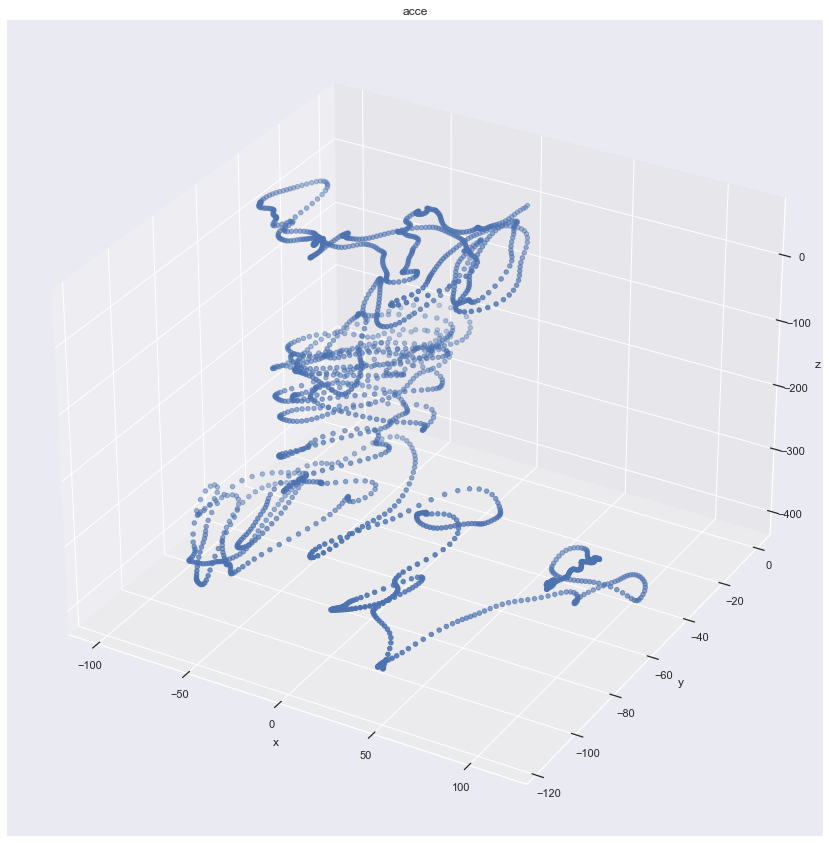

In [16]:

plot_3d_graph(np.cumsum(new_acce[:,0]),np.cumsum(new_acce[:,1]),np.cumsum(new_acce[:,2]))


### Double Integrating the Clean Linear Acceleration to Generate "Better" Position Vectors

In [17]:
time_ = data['Packet number']

vel_0x = integrate.cumtrapz(new_acce[:,0], time_, initial=0)
vel_0y = integrate.cumtrapz(new_acce[:,1], time_, initial=0)
vel_0z = integrate.cumtrapz(new_acce[:,2], time_, initial=0)

pos_0x = integrate.cumtrapz(vel_0x, time_, initial=0)
pos_0y = integrate.cumtrapz(vel_0y, time_, initial=0)
pos_0z = integrate.cumtrapz(vel_0z, time_, initial=0)

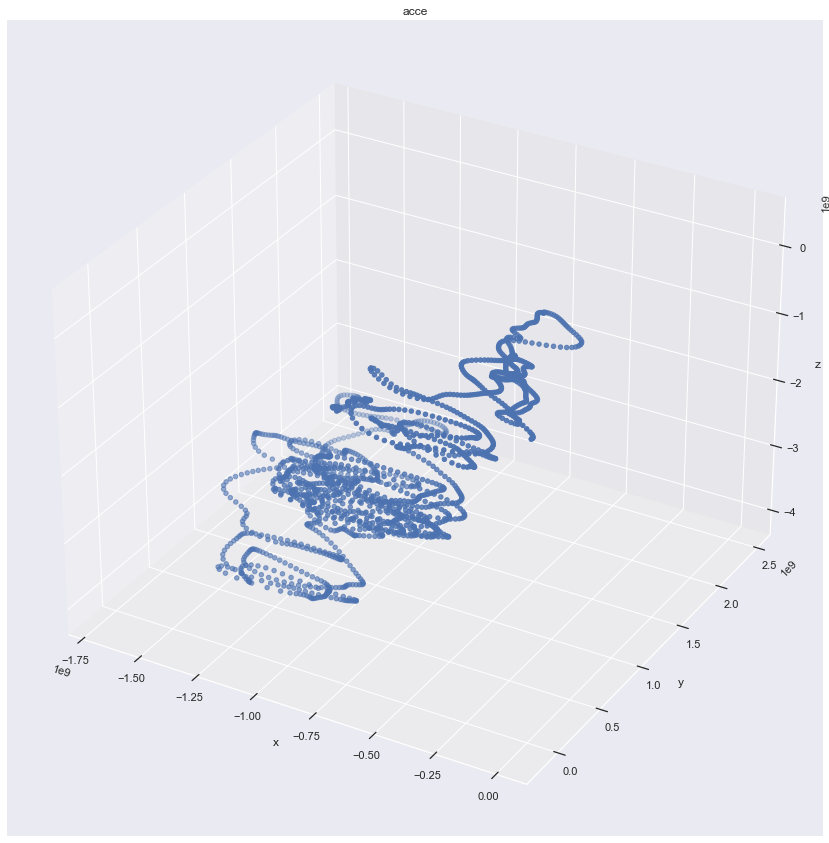

In [18]:
plot_3d_graph(
    vel_x,
    vel_y,
    vel_z,
)

### Better Position Plot

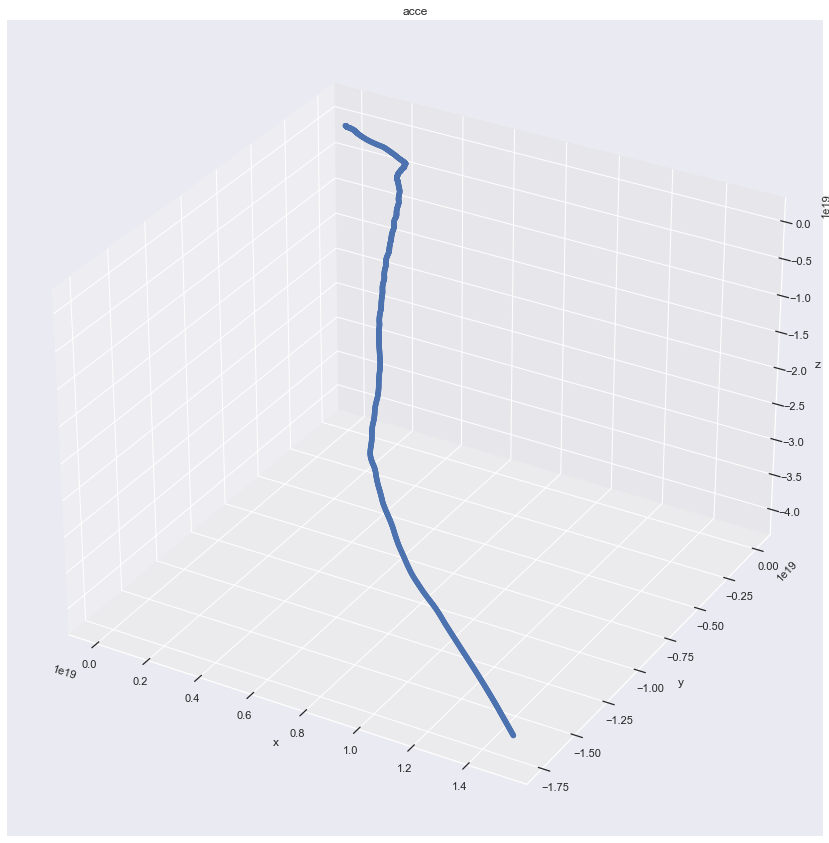

In [19]:
plot_3d_graph(
    pos_y,
    pos_x,
    pos_z,
)

I read up somewhere that the axis may get switched up during the calculations, so to confirm our result, am confirming to see which axis has the least effect on the plot (It should be the Z axis as there is not much movement in that space.)

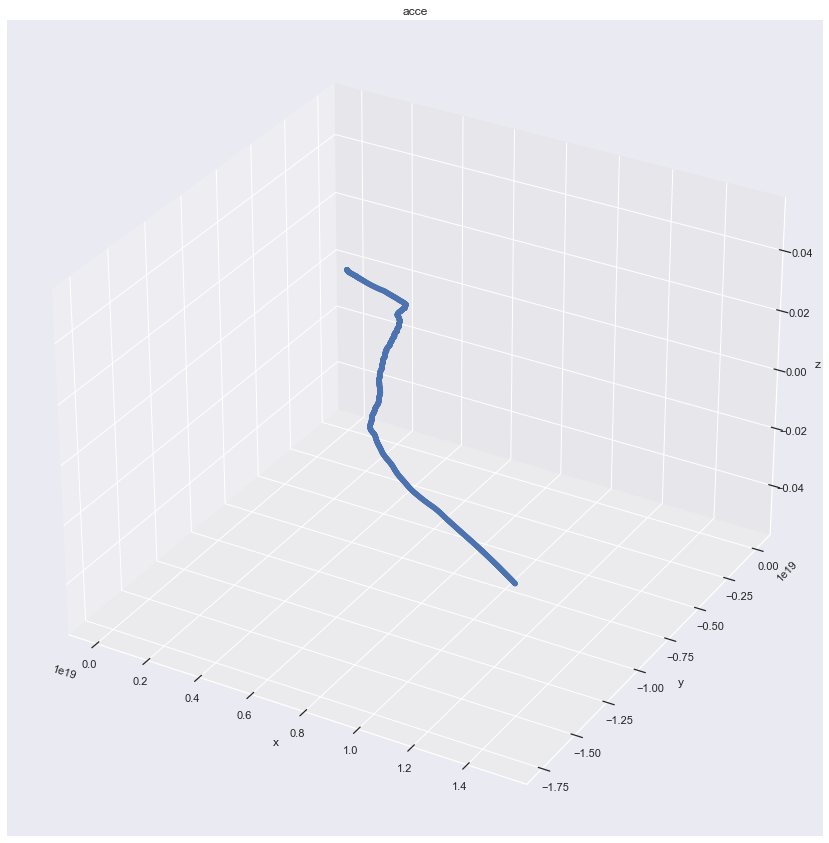

In [20]:
plot_3d_graph(
    pos_y,
    pos_x,
    np.zeros_like(pos_z),
)


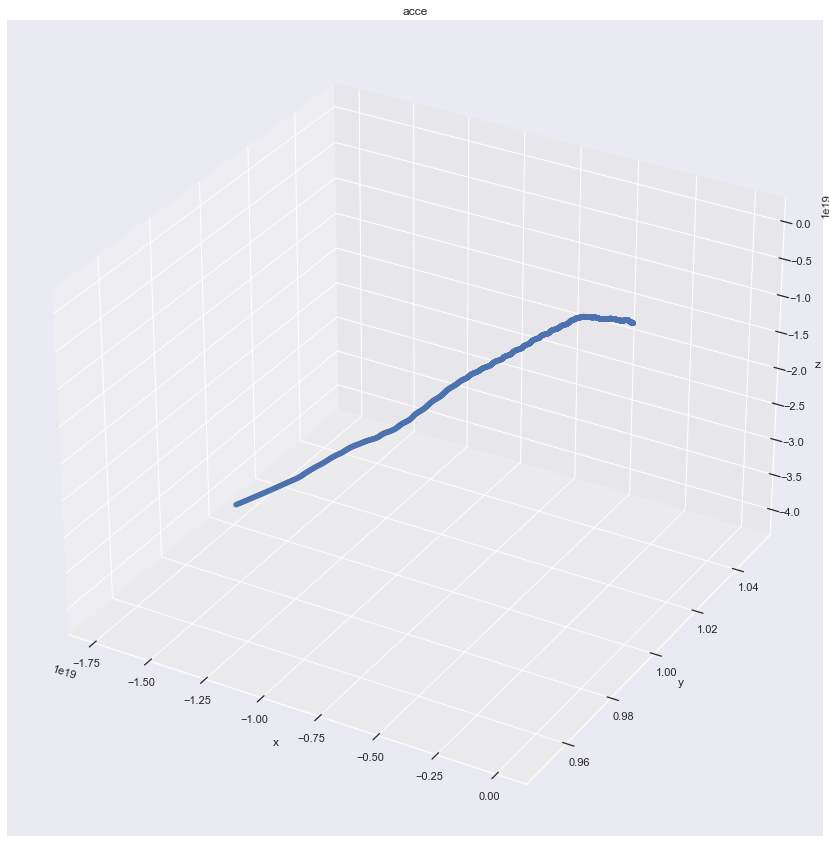

In [21]:
plot_3d_graph(
    pos_x,
    np.ones_like(pos_y),
    pos_z,
)


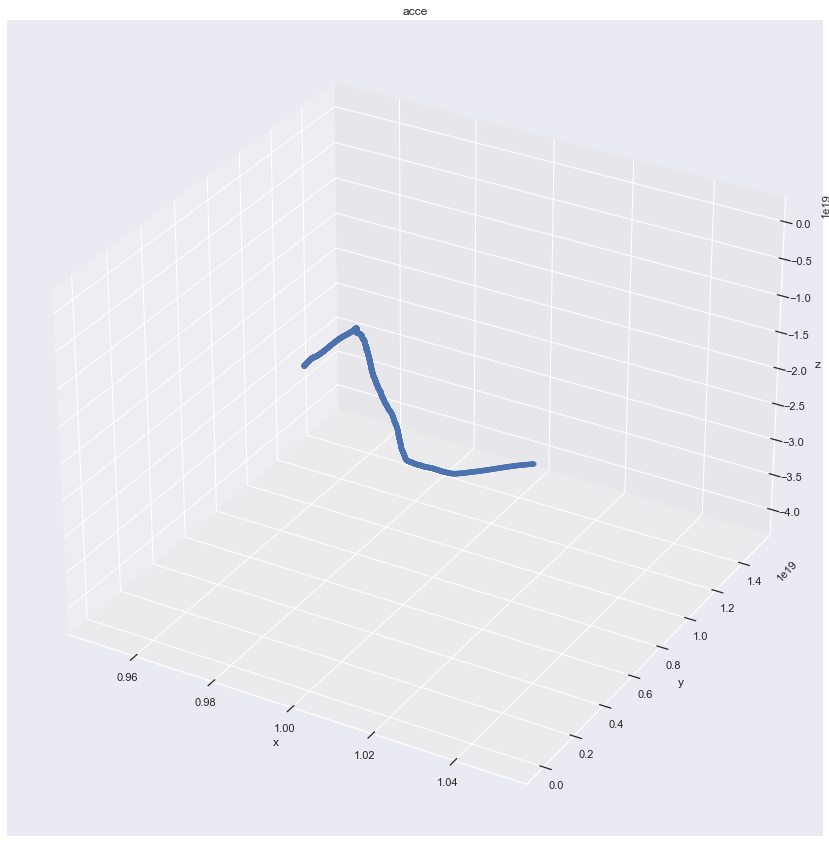

In [22]:
plot_3d_graph(
    np.ones_like(pos_x),
    pos_y,
    pos_z,
)


# VUSIALISATION OUR  DATA 

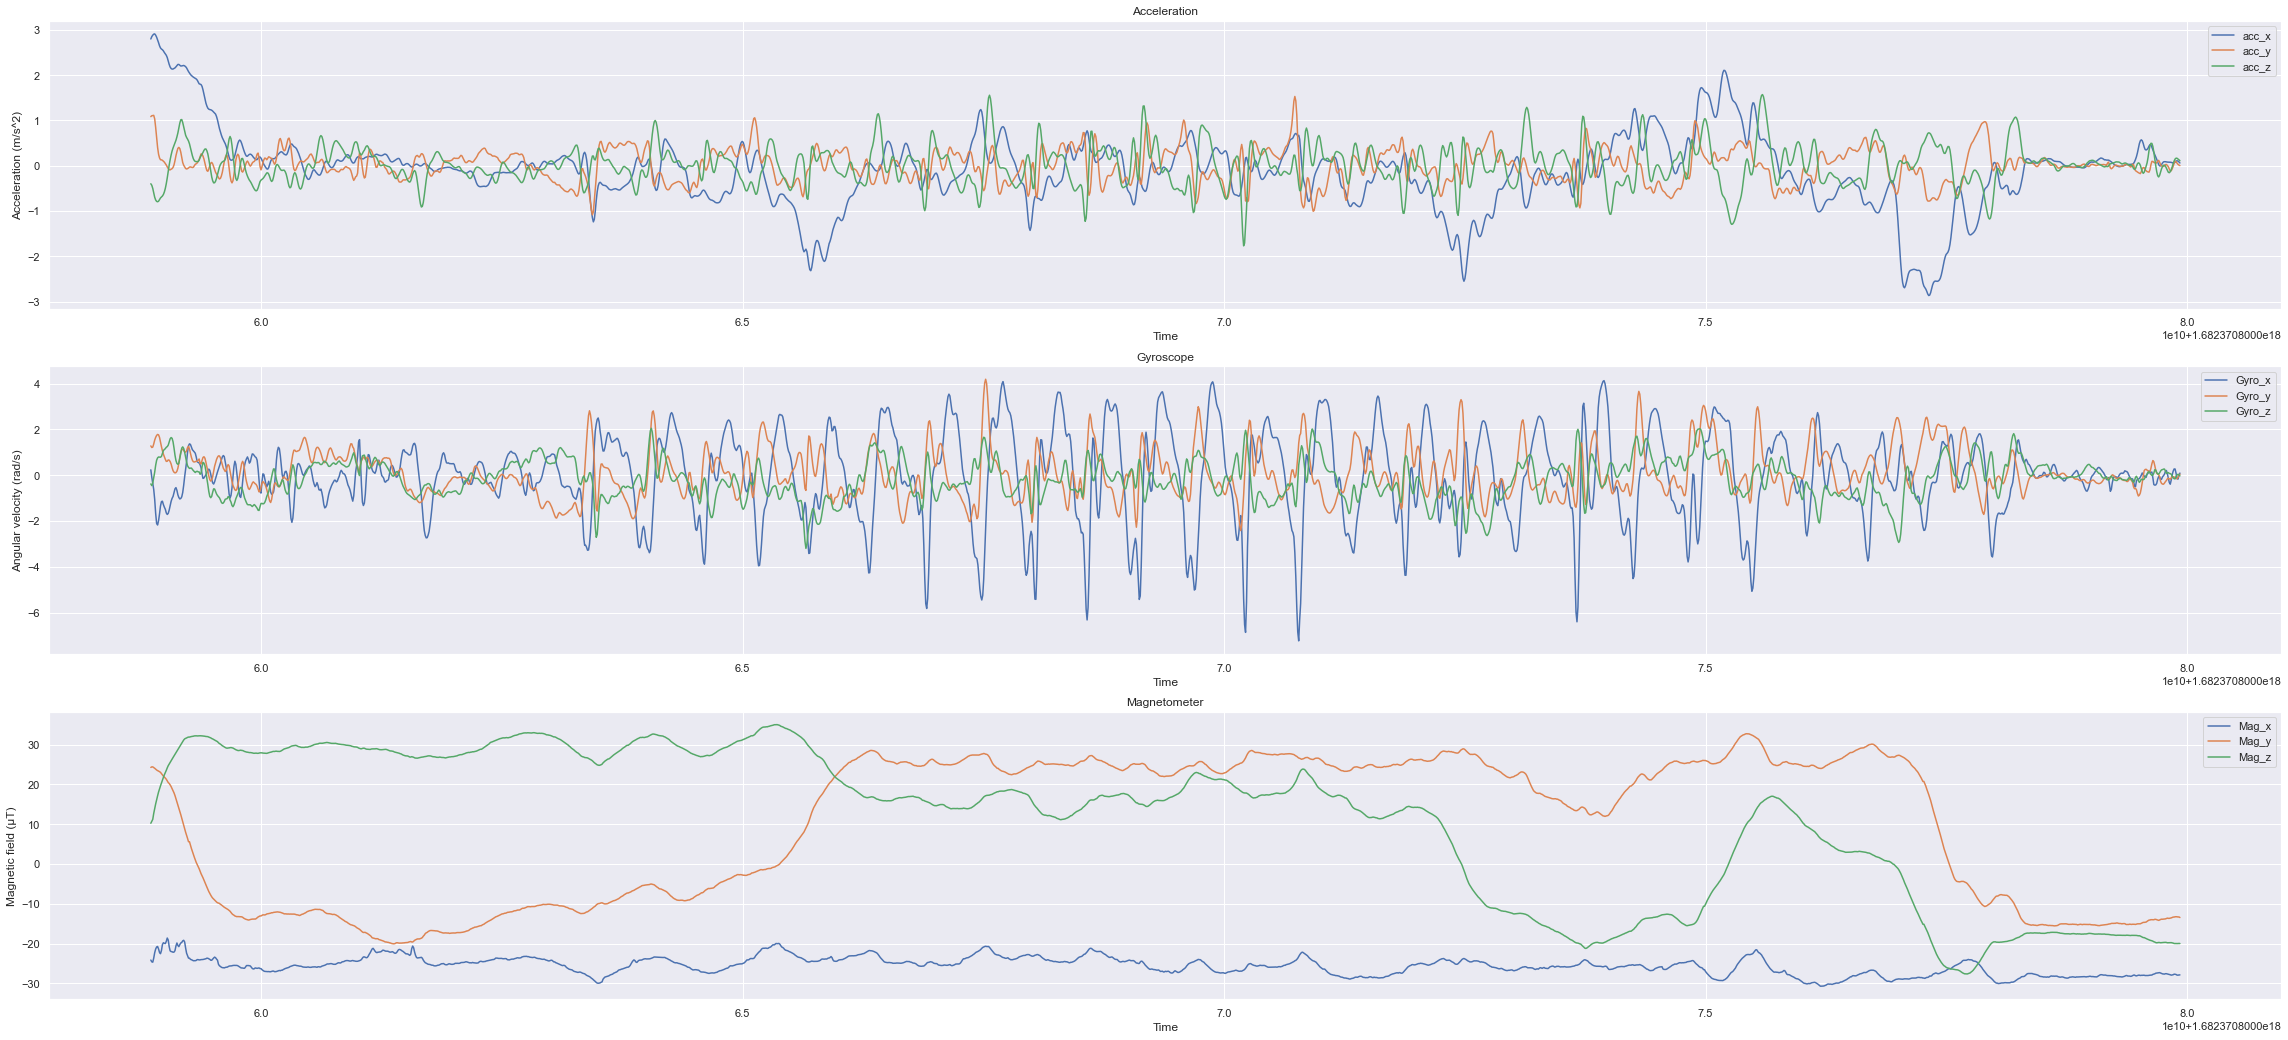

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(40, 18))
time=data['Packet number']

axs[0].plot(time, data.iloc[:,1], label='acc_x')
axs[0].plot(time, data.iloc[:,2], label='acc_y')
axs[0].plot(time, data.iloc[:,3], label='acc_z')
axs[0].set_title('Acceleration')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Acceleration (m/s^2)')
axs[0].legend()

axs[1].plot(time, data.iloc[:,4], label='Gyro_x')
axs[1].plot(time, data.iloc[:,5], label='Gyro_y')
axs[1].plot(time, data.iloc[:,6], label='Gyro_z')
axs[1].set_title('Gyroscope')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Angular velocity (rad/s)')
axs[1].legend()

axs[2].plot(time, data.iloc[:,7], label='Mag_x')
axs[2].plot(time, data.iloc[:,8], label='Mag_y')
axs[2].plot(time, data.iloc[:,9], label='Mag_z')
axs[2].set_title('Magnetometer')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Magnetic field (µT)')
axs[2].legend()

plt.show()





# Vusialisation to our acceleration velosity and position without SensorFusion

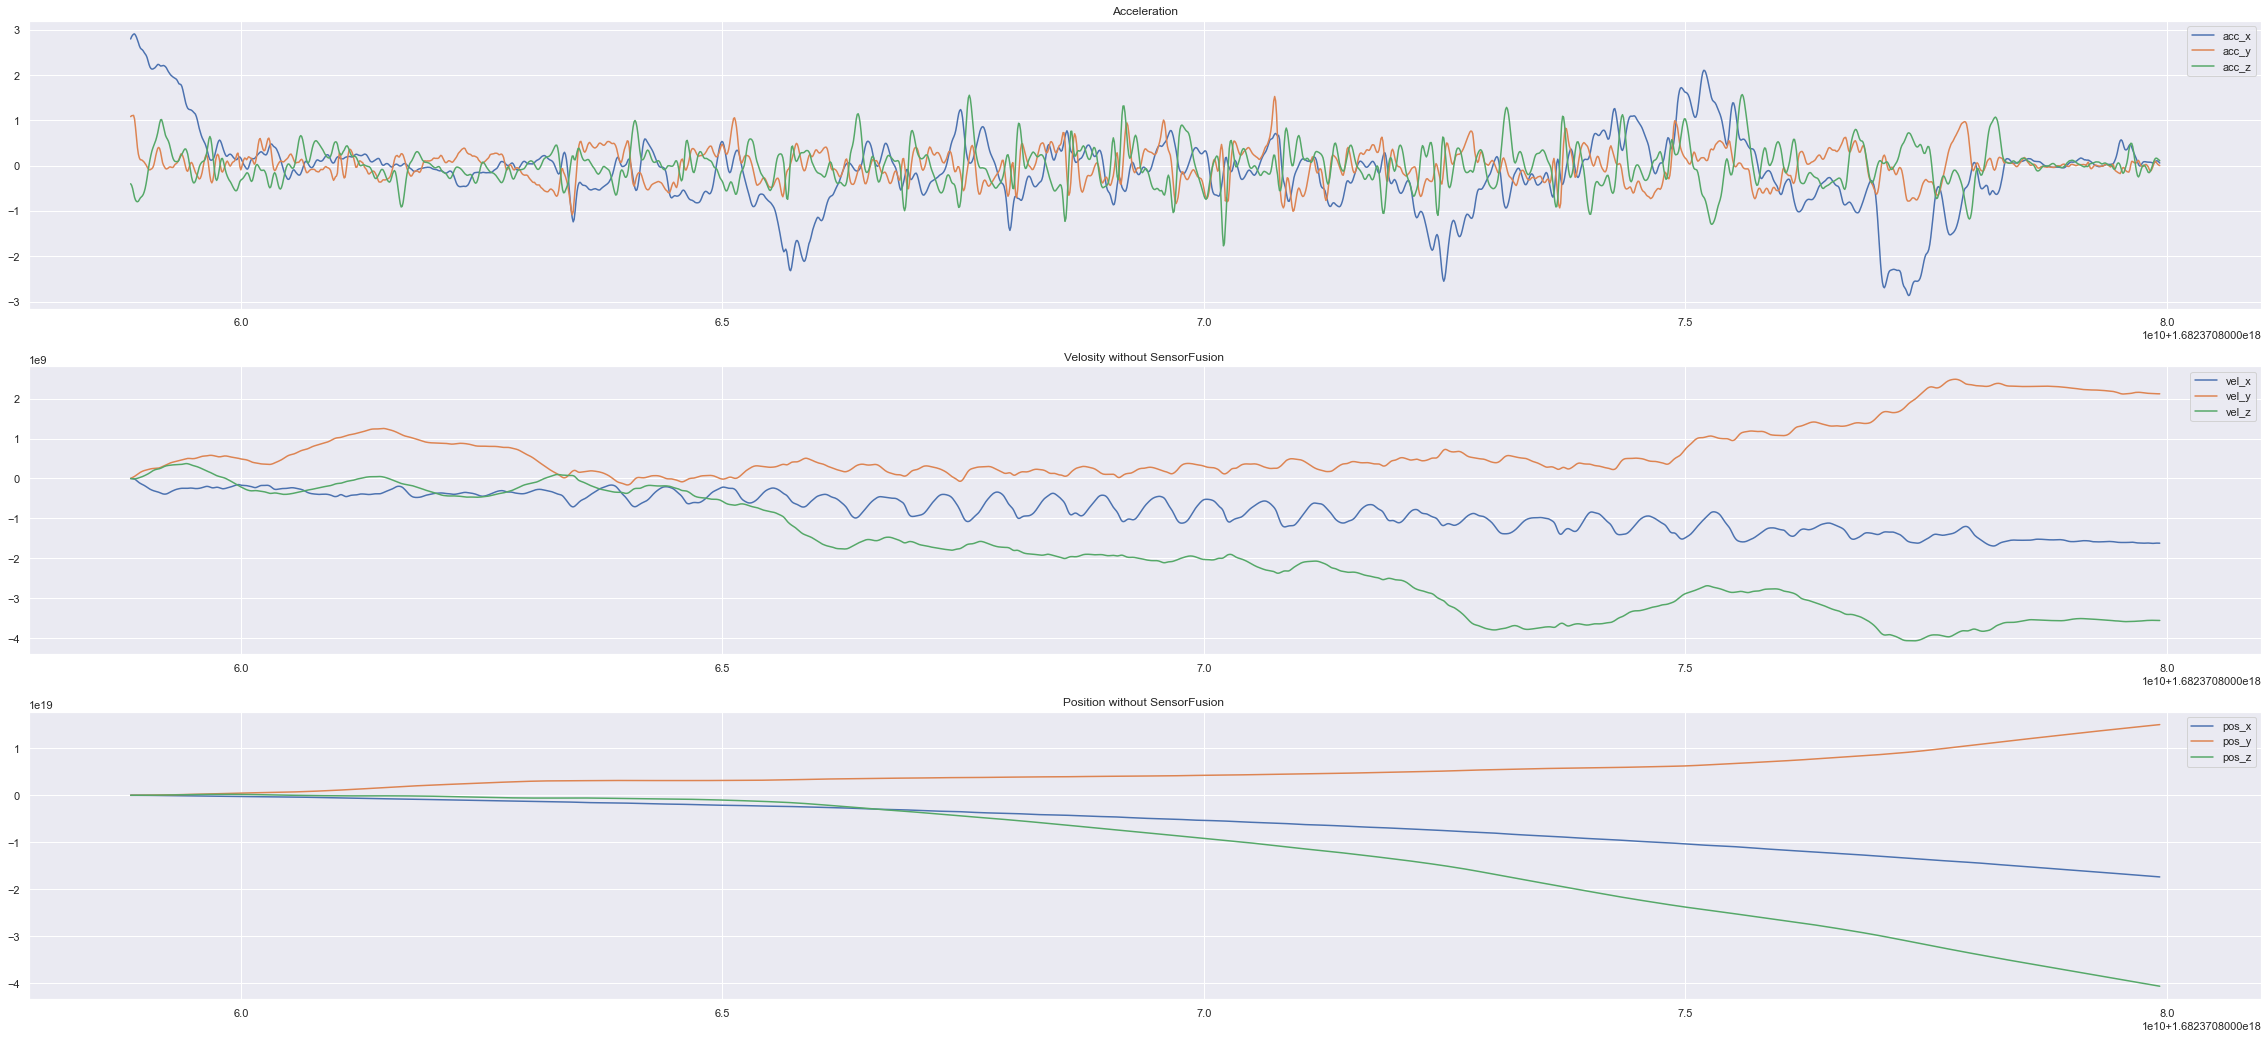

In [24]:
time_ = data['Packet number']

vel_x = integrate.cumtrapz(data['Accelerometer X (g)'], time_, initial=0)
vel_y = integrate.cumtrapz(data['Accelerometer Y (g)'], time_, initial=0)
vel_z = integrate.cumtrapz(data['Accelerometer Z (g)'], time_, initial=0)

pos_x = integrate.cumtrapz(vel_x, time_, initial=0)
pos_y = integrate.cumtrapz(vel_y, time_, initial=0)
pos_z = integrate.cumtrapz(vel_z, time_, initial=0)



fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(40, 18))
time=data['Packet number']

axs[0].plot( time, data.iloc[:,1], label='acc_x')
axs[0].plot( time, data.iloc[:,2], label='acc_y')
axs[0].plot( time, data.iloc[:,3], label='acc_z')
axs[0].set_title('Acceleration')
axs[0].legend()
axs[1].plot( time, vel_x, label='vel_x')
axs[1].plot( time, vel_y, label='vel_y')
axs[1].plot( time, vel_z, label='vel_z')
axs[1].set_title('Velosity without SensorFusion ')
axs[1].legend()



axs[2].plot( time, pos_x, label='pos_x')
axs[2].plot( time, pos_y, label='pos_y')
axs[2].plot( time, pos_z, label='pos_z')
axs[2].set_title('Position without SensorFusion ')

axs[2].legend()




plt.legend()
plt.show()


# Vusialisation to our acceleration velosity and position with SensorFusion

In [25]:
vel_0x = integrate.cumtrapz(new_acce[:,0], time_, initial=0)
vel_0y = integrate.cumtrapz(new_acce[:,1], time_, initial=0)
vel_0z = integrate.cumtrapz(new_acce[:,2], time_, initial=0)

pos_0x = integrate.cumtrapz(vel_0x, time_, initial=0)
pos_0y = integrate.cumtrapz(vel_0y, time_, initial=0)
pos_0z = integrate.cumtrapz(vel_0z, time_, initial=0)

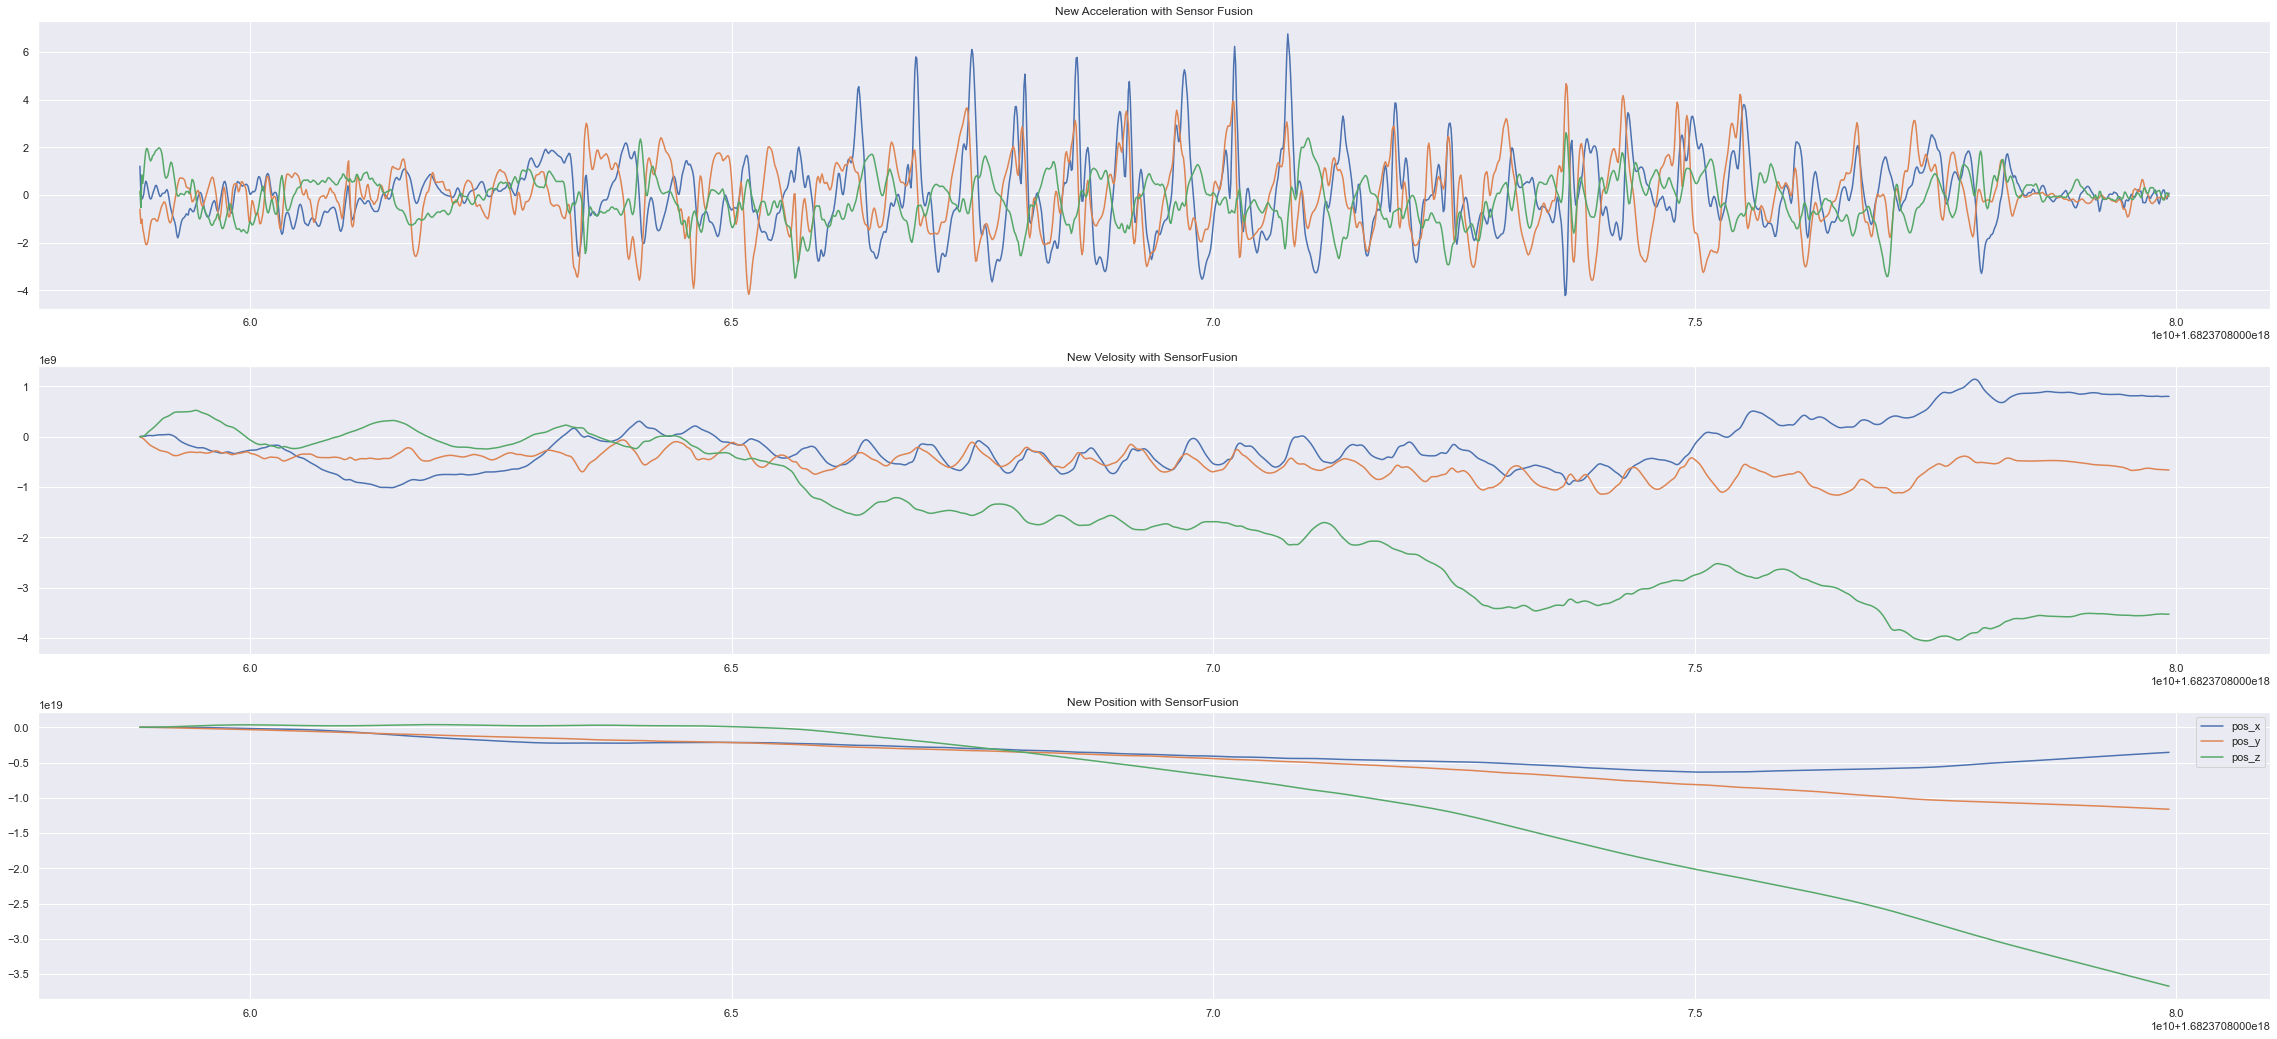

In [26]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(40, 18))
time=data['Packet number']

axs[0].plot( time, new_acce[:,0], label='acc_x')
axs[0].plot( time, new_acce[:,1], label='acc_y')
axs[0].plot( time, new_acce[:,2], label='acc_z')
axs[0].set_title('New Acceleration with Sensor Fusion')

axs[1].plot( time, vel_0x, label='vel_x')
axs[1].plot( time, vel_0y, label='vel_y')
axs[1].plot( time, vel_0z, label='vel_z')
axs[1].set_title('New Velosity with SensorFusion ')



axs[2].plot( time, pos_0x, label='pos_x')
axs[2].plot( time, pos_0y, label='pos_y')
axs[2].plot( time, pos_0z, label='pos_z')
axs[2].set_title('New Position with SensorFusion ')





plt.legend()
plt.show()

# COMPARATION BETWEEN OLD ACC ET ACC WITH SENSOR FUSION 

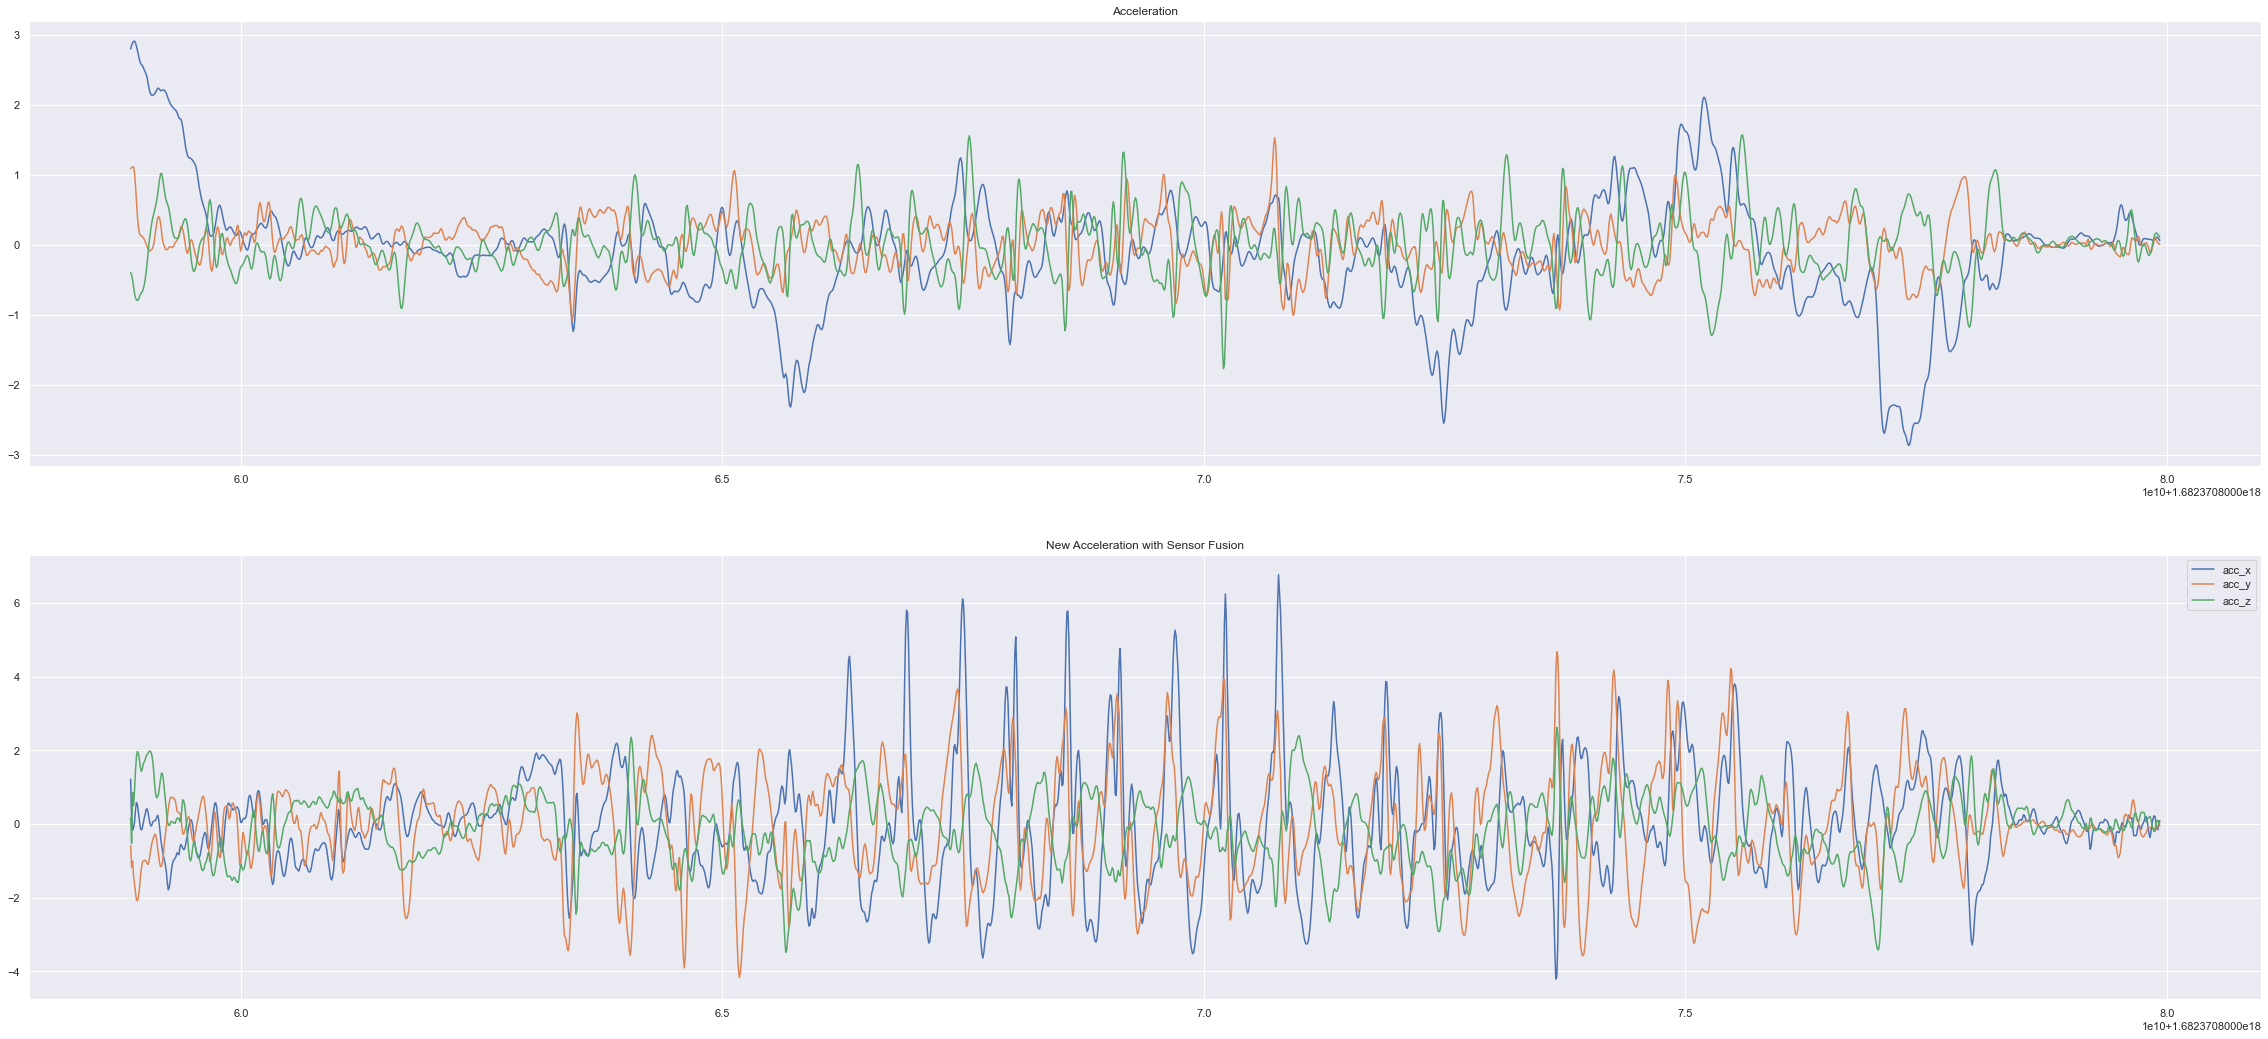

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(40, 18))
time=data['Packet number']



axs[0].plot( time, data.iloc[:,1], label='acc_x')
axs[0].plot( time, data.iloc[:,2], label='acc_y')
axs[0].plot( time, data.iloc[:,3], label='acc_z')
axs[0].set_title('Acceleration')

axs[1].plot( time, new_acce[:,0], label='acc_x')
axs[1].plot( time, new_acce[:,1], label='acc_y')
axs[1].plot( time, new_acce[:,2], label='acc_z')
axs[1].set_title('New Acceleration with Sensor Fusion')







plt.legend()
plt.show()

# CORROLATION BETWEEN OLD ACC AND ACC WITH SONSOR FUSION 

# Comparasation Between velosity with and without Sensor Fusion

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(40, 18))
time=data['Packet number']

axs[0].plot( time, vel_x, label='vel_x')
axs[0].plot( time, vel_y, label='vel_y')
axs[0].plot( time, vel_z, label='vel_z')
axs[0].set_title('Velosity without SensorFusion ')

axs[1].plot( time, vel_0x, label='vel_x')
axs[1].plot( time, vel_0y, label='vel_y')
axs[1].plot( time, vel_0z, label='vel_z')
axs[1].set_title('New Velosity with SensorFusion ')


plt.legend()
plt.show()

 # Comparasation Between Position with and without Sensor Fusion


In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(40, 18))
time=data['Packet number']

axs[0].plot( time, pos_0x, label='pos_x')
axs[0].plot( time, pos_0y, label='pos_y')
axs[0].plot( time, pos_0z, label='pos_z')
axs[0].set_title('New Position with SensorFusion ')

axs[1].plot( time, pos_x, label='pos_x')
axs[1].plot( time, pos_y, label='pos_y')
axs[1].plot( time, pos_z, label='pos_z')
axs[1].set_title('Position without SensorFusion ')



plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(40, 18))
time=data['Packet number']

axs[0].plot( time, pos_x, label='pos_x')
axs[0].plot( time, pos_0x, label='pos_0x')


axs[0].set_title('pos_x vs  Newpos_x')

axs[1].plot( time, pos_y, label='pos_y')
axs[1].plot( time, pos_0y, label='pos_0y')
axs[1].set_title('pos_y vs  Newpos_y ')


axs[2].plot( time, pos_z, label='pos_x')
axs[2].plot( time, pos_0z, label='pos_y')
axs[2].set_title('Pos_z vs Newpos_z ')




plt.legend()
plt.show()

# Comparaison for Predected tragectory with and Without SensorFusion

In [ ]:



fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

axs[0].plot( pos_x, pos_y, label='pos_x')
axs[1].plot( pos_0x, pos_0y, label='pos_z')
axs[0].set_title(' Position without SensorFusion ')
axs[1].set_title('New Position with SensorFusion ')
axs[2].imshow(image_data, cmap='gray')
axs[2].set_title('Real Tragectory')
# Plot the third image

plt.legend()
plt.show()

# Predicted Tragectory with SensorFusion Technique

In [ ]:
plot_3d_graph(
    pos_0x,
    pos_0y,
    pos_0z,
)

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
image_data = mpimg.imread('Capture d’écran 2023-05-27 031903.jpg')

# Create a new figure
fig = plt.figure(figsize=(18,13))

# Plot the first 3D figure
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter( pos_0x,pos_0y, pos_0z)
ax1.set_title('3d Tragectory Prediction with SensorFusion ')

# Plot the second 3D figure
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter( pos_x,pos_y, pos_z)
ax2.set_title('3d Tragectory Prediction without SensorFusion')

# Plot the third image
ax3 = fig.add_subplot(133)
ax3.imshow(image_data, cmap='gray')
ax3.set_title('Real Tragectory')
# Show the plot
plt.show()